In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
print("=== FIXED SALES FORECASTING PIPELINE ===")
df = pd.read_csv("../data/customer_intelligence_dataset.csv")
df['sale_date'] = pd.to_datetime(df['sale_date'], errors="coerce")
print(f"Data loaded: {df.shape[0]} transactions")
print(f"Date range: {df['sale_date'].min()} to {df['sale_date'].max()}")

=== FIXED SALES FORECASTING PIPELINE ===
Data loaded: 8000 transactions
Date range: 2020-01-01 00:00:00 to 2023-12-31 00:00:00


In [15]:
def create_time_series_features(df):
    df['year_month'] = df['sale_date'].dt.to_period('M')
    monthly_sales = df.groupby('year_month').agg({
        'total_value': 'sum',
        'quantity': ['sum', 'mean'],
        'price': 'mean',
        'customer_id': 'nunique',
        'product_id': 'nunique',
        'age': 'mean'
    }).round(2)
    monthly_sales.columns = ['_'.join(col).strip() for col in monthly_sales.columns]
    monthly_sales = monthly_sales.reset_index()
    monthly_sales['date'] = monthly_sales['year_month'].dt.start_time
    return monthly_sales
monthly_data = create_time_series_features(df)
print(f"\nMonthly aggregation: {len(monthly_data)} time periods")


Monthly aggregation: 48 time periods


In [16]:
def engineer_forecasting_features(monthly_df):
    forecasting_df = monthly_df.copy()
    forecasting_df['month'] = forecasting_df['date'].dt.month
    forecasting_df['quarter'] = forecasting_df['date'].dt.quarter
    forecasting_df['year'] = forecasting_df['date'].dt.year
    forecasting_df['month_sin'] = np.sin(2 * np.pi * forecasting_df['month'] / 12)
    forecasting_df['month_cos'] = np.cos(2 * np.pi * forecasting_df['month'] / 12)
    forecasting_df['customers_lag1'] = forecasting_df['customer_id_nunique'].shift(1)
    forecasting_df['customers_lag2'] = forecasting_df['customer_id_nunique'].shift(2)
    forecasting_df['quantity_lag1'] = forecasting_df['quantity_sum'].shift(1)
    forecasting_df['price_lag1'] = forecasting_df['price_mean'].shift(1)
    forecasting_df['customers_ma3'] = forecasting_df['customer_id_nunique'].rolling(window=3).mean()
    forecasting_df['quantity_ma3'] = forecasting_df['quantity_sum'].rolling(window=3).mean()
    forecasting_df['customer_growth'] = forecasting_df['customer_id_nunique'].pct_change()
    forecasting_df['quantity_growth'] = forecasting_df['quantity_sum'].pct_change()
    forecasting_df['customers_x_price'] = forecasting_df['customer_id_nunique'] * forecasting_df['price_mean']
    forecasting_df['quantity_x_price'] = forecasting_df['quantity_sum'] * forecasting_df['price_mean']
    forecasting_df['time_trend'] = range(len(forecasting_df))
    forecasting_df = forecasting_df.dropna()
    return forecasting_df
forecast_df = engineer_forecasting_features(monthly_data)
print(f"\nFeature engineering complete: {len(forecast_df)} periods remaining")


Feature engineering complete: 46 periods remaining


In [17]:
target = 'total_value_sum'
feature_cols = [
    'month', 'quarter', 'month_sin', 'month_cos', 'time_trend',
    'customers_lag1', 'customers_lag2', 'quantity_lag1', 'price_lag1',
    'customers_ma3', 'quantity_ma3',
    'customer_growth', 'quantity_growth',
    'customer_id_nunique', 'product_id_nunique', 'quantity_sum', 'quantity_mean', 'price_mean', 'age_mean',
    'customers_x_price', 'quantity_x_price'
 ]
feature_cols = [col for col in feature_cols if col in forecast_df.columns]
X = forecast_df[feature_cols]
y = forecast_df[target]
print(f"\nSAFE features for modeling: {len(feature_cols)}")
print(f"Features: {feature_cols}")
split_idx = int(len(forecast_df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
print(f"\nTrain periods: {len(X_train)} | Test periods: {len(X_test)}")


SAFE features for modeling: 21
Features: ['month', 'quarter', 'month_sin', 'month_cos', 'time_trend', 'customers_lag1', 'customers_lag2', 'quantity_lag1', 'price_lag1', 'customers_ma3', 'quantity_ma3', 'customer_growth', 'quantity_growth', 'customer_id_nunique', 'product_id_nunique', 'quantity_sum', 'quantity_mean', 'price_mean', 'age_mean', 'customers_x_price', 'quantity_x_price']

Train periods: 36 | Test periods: 10


In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_train = lr_model.predict(X_train_scaled)
y_pred_test = lr_model.predict(X_test_scaled)
def evaluate_model(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mask = y_true != 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 if mask.sum() > 0 else np.inf
    print(f"\n=== {dataset_name} Performance ===")
    print(f"MAE:  ${mae:,.2f}")
    print(f"RMSE: ${rmse:,.2f}")
    print(f"R²:   {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'MAPE': mape}
train_metrics = evaluate_model(y_train, y_pred_train, "Training")
test_metrics = evaluate_model(y_test, y_pred_test, "Testing")


=== Training Performance ===
MAE:  $203,471.30
RMSE: $264,213.15
R²:   0.9489
MAPE: 2.12%

=== Testing Performance ===
MAE:  $600,736.37
RMSE: $680,270.01
R²:   0.7425
MAPE: 6.17%



=== TOP 10 MOST IMPORTANT FEATURES ===
              feature   coefficient
15       quantity_sum  3.500909e+06
20   quantity_x_price -2.873662e+06
17         price_mean  2.676862e+06
7       quantity_lag1 -1.197577e+06
12    quantity_growth -9.764414e+05
10       quantity_ma3  5.922976e+05
0               month  2.973529e+05
11    customer_growth -2.713424e+05
19  customers_x_price -2.179864e+05
1             quarter -2.158815e+05

=== DATA LEAKAGE CHECK ===
R² < 0.95: ✅ PASS
RMSE > 0: ✅ PASS
Reasonable coefficients: ❌ FAIL - Extreme coefficients


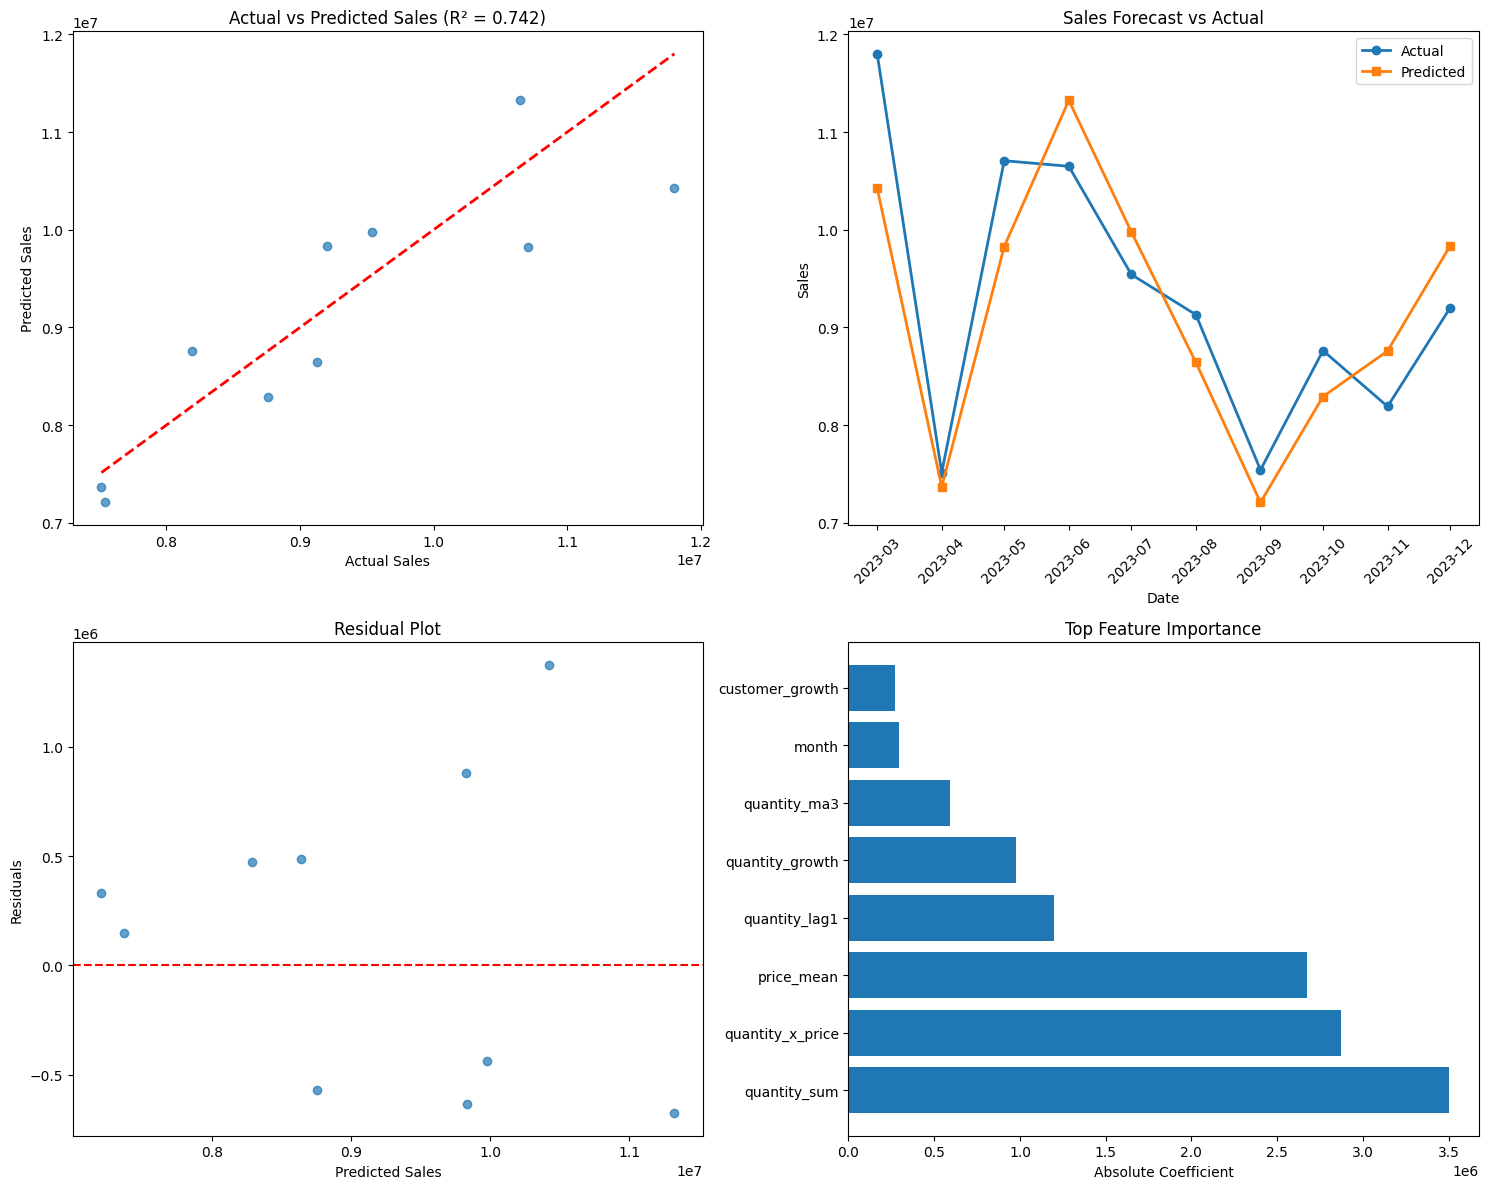


=== FUTURE SALES FORECASTS ===
2024-01: $8,697,182.05
2024-02: $8,720,383.63
2024-03: $8,718,478.33
2024-04: $8,522,445.51
2024-05: $8,542,813.19
2024-06: $8,604,592.70

=== MODEL QUALITY ASSESSMENT ===
✅ Model R² in reasonable range

=== FINAL SUMMARY ===
Model R² Score: 0.7425
Model RMSE: $680,270.01
Model MAPE: 6.17%
Next 6 months forecast range: $8,522,445.51 - $8,720,383.63


In [19]:
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': lr_model.coef_,
    'abs_coefficient': np.abs(lr_model.coef_)
}).sort_values('abs_coefficient', ascending=False)
print(f"\n=== TOP 10 MOST IMPORTANT FEATURES ===")
print(feature_importance.head(10)[['feature', 'coefficient']].round(4))
print(f"\n=== DATA LEAKAGE CHECK ===")
print(f"R² < 0.95: {'✅ PASS' if test_metrics['R2'] < 0.95 else '❌ FAIL - Possible overfitting'}")
print(f"RMSE > 0: {'✅ PASS' if test_metrics['RMSE'] > 0 else '❌ FAIL - Perfect prediction indicates leakage'}")
print(f"Reasonable coefficients: {'✅ PASS' if feature_importance['abs_coefficient'].max() < 1000 else '❌ FAIL - Extreme coefficients'}")
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes[0,0].scatter(y_test, y_pred_test, alpha=0.7)
axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0,0].set_xlabel('Actual Sales')
axes[0,0].set_ylabel('Predicted Sales')
axes[0,0].set_title(f'Actual vs Predicted Sales (R² = {test_metrics["R2"]:.3f})')
test_dates = forecast_df['date'].iloc[split_idx:].values
axes[0,1].plot(test_dates, y_test.values, 'o-', label='Actual', linewidth=2)
axes[0,1].plot(test_dates, y_pred_test, 's-', label='Predicted', linewidth=2)
axes[0,1].set_xlabel('Date')
axes[0,1].set_ylabel('Sales')
axes[0,1].set_title('Sales Forecast vs Actual')
axes[0,1].legend()
axes[0,1].tick_params(axis='x', rotation=45)
residuals = y_test - y_pred_test
axes[1,0].scatter(y_pred_test, residuals, alpha=0.7)
axes[1,0].axhline(y=0, color='r', linestyle='--')
axes[1,0].set_xlabel('Predicted Sales')
axes[1,0].set_ylabel('Residuals')
axes[1,0].set_title('Residual Plot')
top_features = feature_importance.head(8)
axes[1,1].barh(range(len(top_features)), top_features['abs_coefficient'])
axes[1,1].set_yticks(range(len(top_features)))
axes[1,1].set_yticklabels(top_features['feature'])
axes[1,1].set_xlabel('Absolute Coefficient')
axes[1,1].set_title('Top Feature Importance')
plt.tight_layout()
plt.show()
def forecast_future_sales_safe(model, scaler, forecast_df, feature_cols, periods=6):
    future_forecasts = []
    for i in range(periods):
        last_date = forecast_df['date'].iloc[-1]
        next_date = last_date + pd.DateOffset(months=i+1)
        next_features = pd.Series(index=feature_cols, dtype=float)
        next_features['month'] = next_date.month
        next_features['quarter'] = next_date.quarter
        next_features['month_sin'] = np.sin(2 * np.pi * next_date.month / 12)
        next_features['month_cos'] = np.cos(2 * np.pi * next_date.month / 12)
        next_features['time_trend'] = len(forecast_df) + i
        for col in feature_cols:
            if col not in next_features.index or pd.isna(next_features[col]):
                if col in forecast_df.columns:
                    next_features[col] = forecast_df[col].tail(3).mean()
                else:
                    next_features[col] = 0
        next_features_scaled = scaler.transform([next_features.values])
        prediction = model.predict(next_features_scaled)[0]
        future_forecasts.append({
            'date': next_date,
            'predicted_sales': max(prediction, 0),
            'period': i + 1
        })
    return pd.DataFrame(future_forecasts)
future_predictions = forecast_future_sales_safe(lr_model, scaler, forecast_df, feature_cols, periods=6)
print(f"\n=== FUTURE SALES FORECASTS ===")
for _, row in future_predictions.iterrows():
    print(f"{row['date'].strftime('%Y-%m')}: ${row['predicted_sales']:,.2f}")
print(f"\n=== MODEL QUALITY ASSESSMENT ===")
if test_metrics['R2'] > 0.95:
    print("⚠️  WARNING: R² too high, possible overfitting")
elif test_metrics['R2'] < 0.3:
    print("⚠️  WARNING: R² too low, model may not be capturing patterns")
else:
    print("✅ Model R² in reasonable range")
print(f"\n=== FINAL SUMMARY ===")
print(f"Model R² Score: {test_metrics['R2']:.4f}")
print(f"Model RMSE: ${test_metrics['RMSE']:,.2f}")
print(f"Model MAPE: {test_metrics['MAPE']:,.2f}%")
print(f"Next 6 months forecast range: ${future_predictions['predicted_sales'].min():,.2f} - ${future_predictions['predicted_sales'].max():,.2f}")

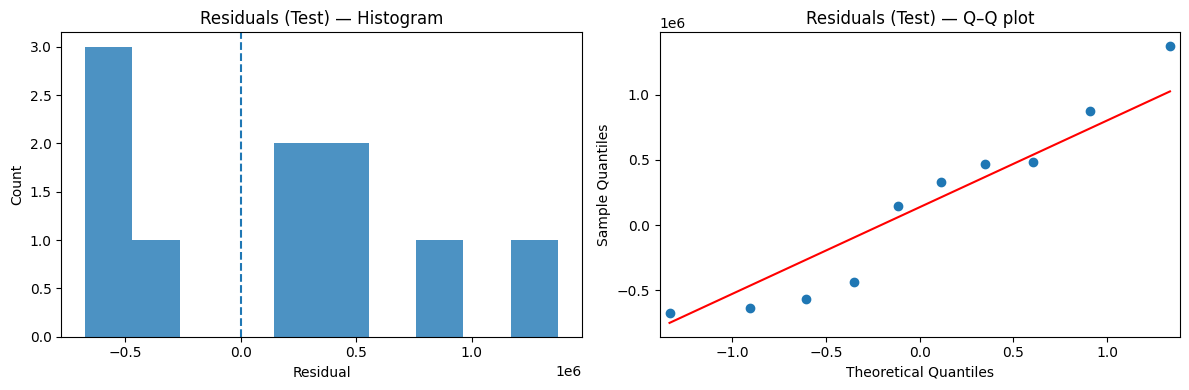

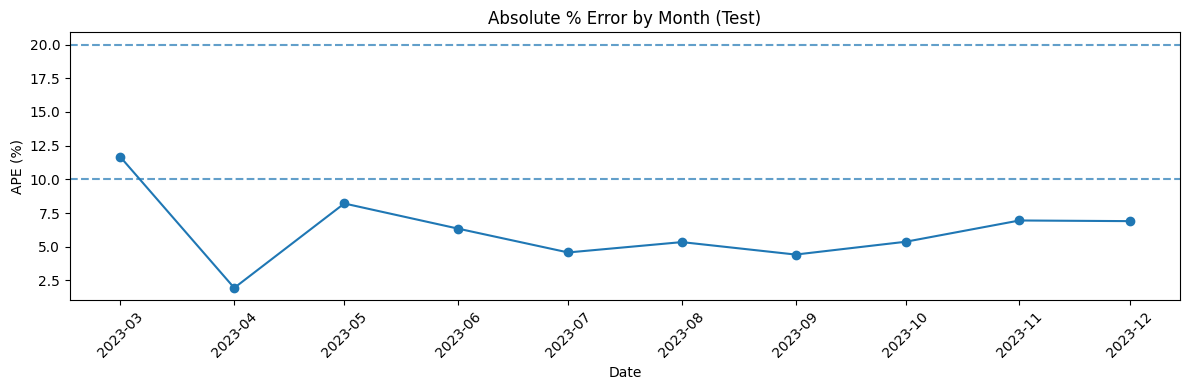

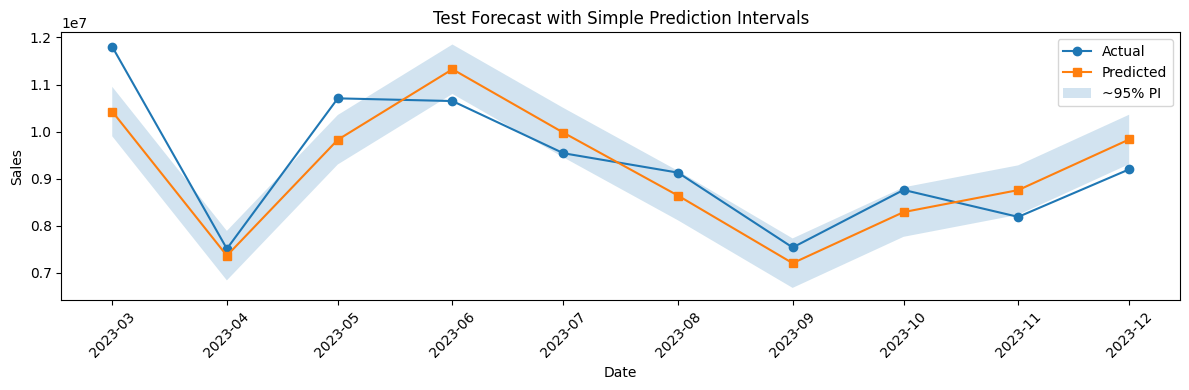

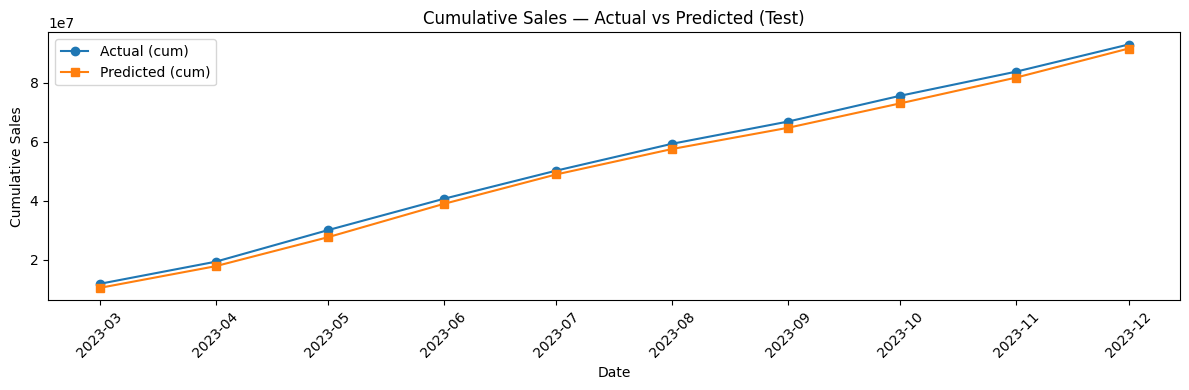

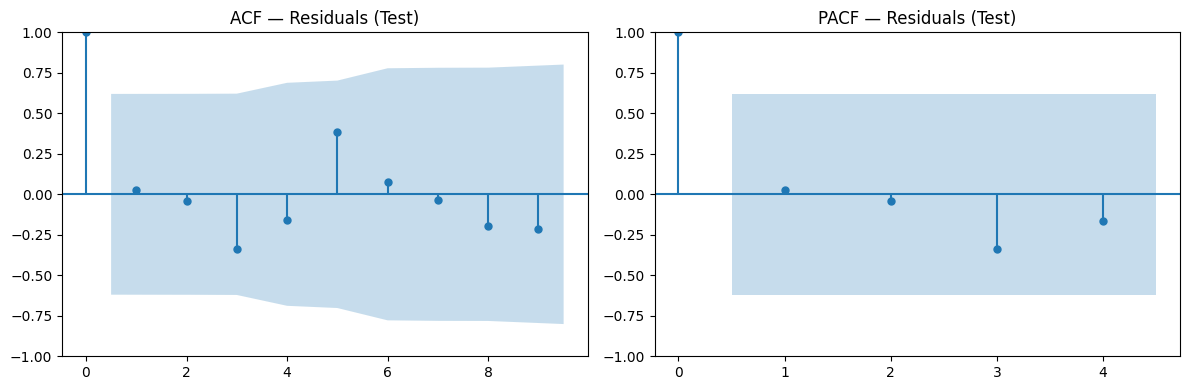

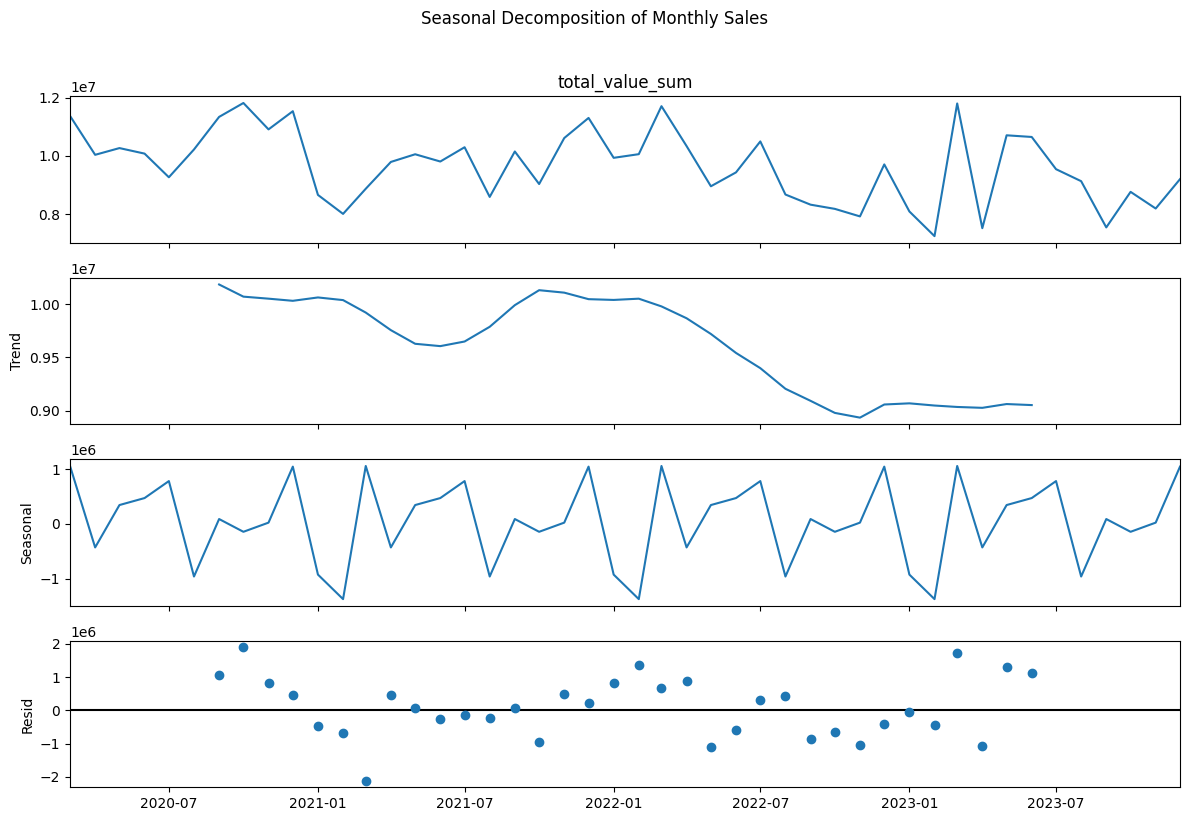

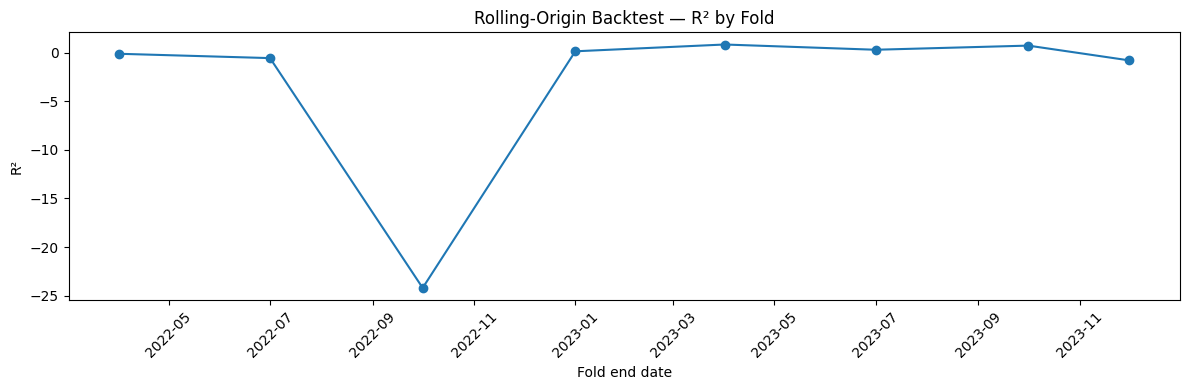

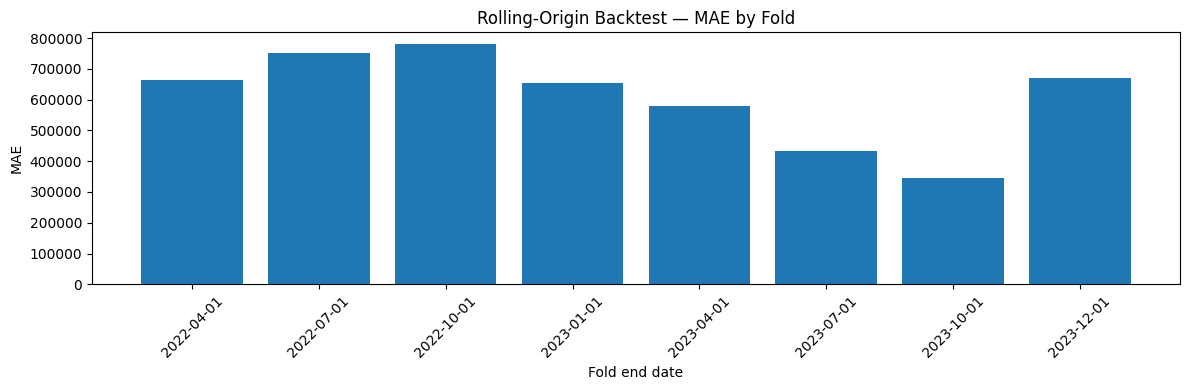

In [21]:

try:
    y_pred_train
except NameError:
    X_train_scaled = scaler.transform(X_train)
    y_pred_train = lr_model.predict(X_train_scaled)

resid_train = y_train - y_pred_train
resid_test  = y_test  - y_pred_test

# For time-aware plots
test_dates = forecast_df['date'].iloc[split_idx:].reset_index(drop=True)
train_dates = forecast_df['date'].iloc[:split_idx].reset_index(drop=True)

# 1) Residual distribution + Q–Q plot (test set)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(resid_test, bins=10, alpha=0.8)
axes[0].axvline(0, ls='--')
axes[0].set_title("Residuals (Test) — Histogram")
axes[0].set_xlabel("Residual"); axes[0].set_ylabel("Count")

sm.ProbPlot(resid_test).qqplot(line="s", ax=axes[1])
axes[1].set_title("Residuals (Test) — Q–Q plot")
plt.tight_layout()
plt.show()

# 2) Error over time (absolute % error)
ape = (resid_test.abs() / y_test.values) * 100
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(test_dates, ape, marker='o')
ax.axhline(10, ls='--', alpha=0.7)
ax.axhline(20, ls='--', alpha=0.7)
ax.set_title("Absolute % Error by Month (Test)")
ax.set_xlabel("Date"); ax.set_ylabel("APE (%)")
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

# 3) Actual vs Predicted with simple 95% prediction intervals (σ from train residuals)
sigma = resid_train.std(ddof=1)
upper = y_pred_test + 1.96 * sigma
lower = y_pred_test - 1.96 * sigma

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(test_dates, y_test.values, 'o-', label='Actual')
ax.plot(test_dates, y_pred_test, 's-', label='Predicted')
ax.fill_between(test_dates, lower, upper, alpha=0.2, label='~95% PI')
ax.set_title("Test Forecast with Simple Prediction Intervals")
ax.set_xlabel("Date"); ax.set_ylabel("Sales")
ax.legend()
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

# 4) Cumulative actual vs predicted (test)
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(test_dates, np.cumsum(y_test.values), 'o-', label='Actual (cum)')
ax.plot(test_dates, np.cumsum(y_pred_test), 's-', label='Predicted (cum)')
ax.set_title("Cumulative Sales — Actual vs Predicted (Test)")
ax.set_xlabel("Date"); ax.set_ylabel("Cumulative Sales")
ax.legend()
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

# 5) ACF/PACF of residuals (test)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
max_pacf_lags = min(12, (len(resid_test) // 2) - 1)
plot_acf(resid_test, lags=min(12, len(resid_test)-1), ax=axes[0])
axes[0].set_title("ACF — Residuals (Test)")
plot_pacf(resid_test, lags=max_pacf_lags, ax=axes[1], method='ywm')
axes[1].set_title("PACF — Residuals (Test)")
plt.tight_layout(); plt.show()

# 6) Seasonal decomposition of the target (full monthly series)
from statsmodels.tsa.seasonal import seasonal_decompose
series = forecast_df.set_index('date')['total_value_sum']
decomp = seasonal_decompose(series, model='additive', period=12)
fig = decomp.plot()
fig.set_size_inches(12, 8)
fig.suptitle("Seasonal Decomposition of Monthly Sales", y=1.02)
plt.tight_layout(); plt.show()

# 7) Rolling-origin backtest (expanding window) — quick view of stability
def rolling_origin_backtest(df, feature_cols, target='total_value_sum', start_frac=0.5, steps=6):
    n = len(df)
    start = int(n * start_frac)
    step = max(1, (n - start) // steps)
    rows = []
    for i in range(start, n - 1, step):
        train = df.iloc[:i]
        test  = df.iloc[i:i+step]

        Xtr = train[feature_cols]; ytr = train[target]
        Xte = test[feature_cols];  yte = test[target]

        # fresh scaler/model per fold
        from sklearn.preprocessing import StandardScaler
        from sklearn.linear_model import LinearRegression
        sc = StandardScaler().fit(Xtr)
        m  = LinearRegression().fit(sc.transform(Xtr), ytr)

        yhat = m.predict(sc.transform(Xte))
        r2  = r2_score(yte, yhat)
        mae = mean_absolute_error(yte, yhat)
        rows.append({"fold_end": test['date'].iloc[-1], "R2": r2, "MAE": mae})
    return pd.DataFrame(rows)

# Build a safe frame that contains all features & target
safe_cols = ['date', 'total_value_sum'] + [c for c in feature_cols if c in forecast_df.columns]
bt_df = forecast_df[safe_cols].dropna().reset_index(drop=True)
bt = rolling_origin_backtest(bt_df, [c for c in feature_cols if c in bt_df.columns])

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(bt['fold_end'], bt['R2'], marker='o')
ax.set_title("Rolling-Origin Backtest — R² by Fold")
ax.set_xlabel("Fold end date"); ax.set_ylabel("R²")
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(bt['fold_end'].astype(str), bt['MAE'])
ax.set_title("Rolling-Origin Backtest — MAE by Fold")
ax.set_xlabel("Fold end date"); ax.set_ylabel("MAE")
plt.xticks(rotation=45); plt.tight_layout(); plt.show()
